<a href="https://colab.research.google.com/github/bindhujk/web_mining_project/blob/main/Web_mining_with_100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095445 sha256=a67e2149ec567b4574efc27da7ce2b982dd1a548b0effbfbc77d0d1113238f5a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import csv
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from pdb import set_trace
from surprise.accuracy import mse, rmse, mae
from surprise import Dataset, Reader, KNNBasic
import seaborn as sns

In [ ]:
import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def make_csv_file(srcfile, targetfile):
    with open(srcfile, 'r') as dat_file:
        with open(targetfile, 'w', newline='', encoding = 'utf-8') as csv_file:
            csv_writer = csv.writer(csv_file)
            for row in dat_file:
                row = [value.strip() for value in row.split('::')]
                csv_writer.writerow(row)

In [ ]:
df_ratings = pd.read_csv('/content/gdrive/MyDrive/ratings_100.csv')
df_users = pd.read_csv('/content/gdrive/MyDrive/users_100.csv')

In [ ]:
df_movies = pd.read_csv('/content/gdrive/MyDrive/movies_100.csv')


In [ ]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df_ratings['Rating'].mean()

3.52986

In [ ]:
df_movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,GoldenEye (1995),Action|Adventure|Thriller
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),Action|Comedy|Drama
4,5,Copycat (1995),Crime|Drama|Thriller
...,...,...,...
1677,1678,Mat' i syn (1997),Drama
1678,1679,B. Monkey (1998),Romance|Thriller
1679,1680,Sliding Doors (1998),Drama|Romance
1680,1681,You So Crazy (1994),Comedy


In [ ]:
df_users

,UserID,Age,Gender,Occupation,Zip-code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
df_users.loc[df_users['Occupation']==0]

,UserID,Age,Gender,Occupation,Zip-code


## **Exploratory data analysis**

In [ ]:
df_ratings.isna().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [ ]:
df_movies.isna().sum()

MovieID    0
Title      0
Genres     0
dtype: int64

In [ ]:
df_users.isna().sum()

UserID        0
Age           0
Gender        0
Occupation    0
Zip-code      0
dtype: int64

In [ ]:
df_ratings['Rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: Rating, dtype: float64

<Axes: xlabel='Rating', ylabel='Count'>

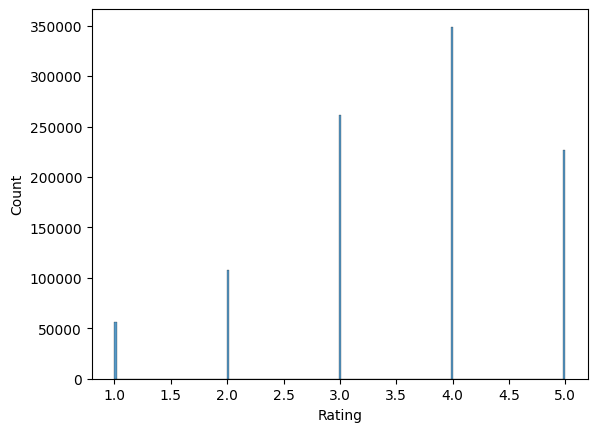

In [ ]:
sns.histplot(df_ratings['Rating'])

## **Data Preprocessing**

Remove features that are not necessary

In [ ]:
df_ratings.drop('Timestamp', axis=1, inplace=True)

Preprocessing 'Title' and 'Genre' column of df_movies dataset

In [ ]:
def year(x):
  x = re.findall('\d{4}', x)
  if len(x) == 0:
    return 0
  else:
    return x[0]

In [ ]:
df_movies['Year'] = df_movies['Title'].apply(year)

In [ ]:
def title(x):
  x = re.sub('(\d{4})', '', x)
  x = re.sub('\([^)]*\)', '', x)
  x = re.sub('[^a-zA-Z]+', ' ', x)
  x = re.sub("'", '', x)
  x = re.sub(r'\\s+', ' ', x)
  return x

In [ ]:
df_movies['Title'] = df_movies['Title'].apply(title)
df_movies['Genres'] = df_movies['Genres'].apply(title)

In [ ]:
df_movies

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation Children s Comedy,1995
1,2,GoldenEye,Action Adventure Thriller,1995
2,3,Four Rooms,Thriller,1995
3,4,Get Shorty,Action Comedy Drama,1995
4,5,Copycat,Crime Drama Thriller,1995
...,...,...,...,...
1677,1678,Mat i syn,Drama,1997
1678,1679,B Monkey,Romance Thriller,1998
1679,1680,Sliding Doors,Drama Romance,1998
1680,1681,You So Crazy,Comedy,1994


Preprocessing 'Gender' and 'Occupation' column of df_users dataset

In [ ]:
df_users['Gender'] = df_users['Gender'].replace({'M': 'Male', 'F': 'Female'})

In [ ]:
import re

def pre(x):
  x = re.sub('[^a-zA-Z]+', ' ', x)
  x = re.sub("'", '', x)
  x = re.sub(r'\\s+', ' ', x)
  return x
df_users['Occupation'] = df_users['Occupation'].apply(pre)

In [ ]:
df_users

,UserID,Age,Gender,Occupation,Zip-code
0,1,24,Male,technician,85711
1,2,53,Female,other,94043
2,3,23,Male,writer,32067
3,4,24,Male,technician,43537
4,5,33,Female,other,15213
...,...,...,...,...,...
938,939,26,Female,student,33319
939,940,32,Male,administrator,02215
940,941,20,Male,student,97229
941,942,48,Female,librarian,78209


### Functions for evaluation metrics

In [ ]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def precision_recall_f1(predictions, threshold=3.5):
    """Return precision, recall and f1 metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    # collect metrics per user
    precisions = dict()
    recalls = dict()
    f1s = dict()
    accuracies = dict()
    
    for uid, user_ratings in user_est_true.items():
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r >= threshold) else 0 for (est_r, _) in user_ratings]
        
        precisions[uid] = precision_score(y_true, y_pred, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred, zero_division=0)

        accuracies[uid] = accuracy_score(y_true, y_pred)

    # average scores over all users 
    avg_precision = sum(list(precisions.values())) / len(list(precisions.values()))
    avg_recall = sum(list(recalls.values())) / len(list(recalls.values()))
    avg_f1 = sum(list(f1s.values())) / len(list(f1s.values()))
    
    avg_accuracy = sum(list(accuracies.values())) / len(list(accuracies.values()))
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [ ]:
from sklearn.metrics import average_precision_score, ndcg_score

def measures_at_k(predictions, k=10, threshold=3.5):
    """Return precision and nDCG at k metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    average_precisions = dict()
    precisions_at_k = dict()
    ndcgs_at_k = dict()

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r > threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r > threshold) else 0 for (est_r, _) in user_ratings]
        
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(y_true, y_pred)
        else:
            average_precisions[uid] = 0

        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        if not len(user_ratings) == 1:
            ndcgs_at_k[uid] = ndcg_score(np.asarray([[x for (_, x) in user_ratings]]), np.asarray([[x for (x, _) in user_ratings]]), k=k)
        elif len(user_ratings) == 1:
            ndcgs_at_k[uid] = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings
        )
            
        # compute simple averages over all users for each score:
        avg_average_precisions = sum(val for val in average_precisions.values()) / len(average_precisions)
        avg_precisions_at_k = sum(val for val in precisions_at_k.values()) / len(precisions_at_k)
        avg_ndcgs_at_k = sum(val for val in ndcgs_at_k.values()) / len(ndcgs_at_k)

    return avg_average_precisions, avg_precisions_at_k, avg_ndcgs_at_k

### Function to generate example recommendations for a user

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## **Collaborative Filtering**

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_ratings[['UserID','MovieID','Rating']], reader)

### **Baseline models**

### 1. KNNBasic

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=my_seed)

In [ ]:
sim_options = {'name': 'pearson', 'user_based': True, 'min_support': 1}

algo = KNNBasic(sim_options=sim_options, k=10)

algo.fit(trainset)
predictions_knn = algo.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
mse(predictions_knn)
rmse(predictions_knn)
mae(predictions_knn);

MSE: 1.1002
RMSE: 1.0489
MAE:  0.8336


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_knn, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.6730567192891691
Avg. Recall: 0.689702601889619
Avg. F1: 0.6519861422166865
Avg. Accuracy: 0.6443137010780204


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_knn, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6596171295251162
Avg. Precision@5: 0.7371903750884643
Avg. nDCG@5: 0.8706627044620174


### 2. SVD

In [ ]:
from surprise import SVD

algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions_svd = algo.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_svd)
rmse(predictions_svd)
mae(predictions_svd);

MSE: 0.9398
RMSE: 0.9694
MAE:  0.7765


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_svd, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.670893862039651
Avg. Recall: 0.6801836995528794
Avg. F1: 0.6466521972893047
Avg. Accuracy: 0.6975558970084743


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_svd, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6565959198754373
Avg. Precision@5: 0.7360226468506714
Avg. nDCG@5: 0.8801782149234739


### **Hyperparameter tuning**

In [ ]:
!pip install auto_surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import Dataset
from surprise import Reader
from auto_surprise.engine import Engine
import pandas as pd


# Create a reader object with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the dataframe
data = Dataset.load_from_df(df_ratings[['UserID', 'MovieID', 'Rating']], reader)

# Intitialize auto surprise engine
engine = Engine(verbose=True)

# Start the trainer
best_algo, best_params, best_score, tasks = engine.train(
    data=data,
    target_metric='test_rmse', # The metric we seek to minimize
    cpu_time_limit=60 * 60, # The time limit we want to train in seconds
    max_evals=100 # The maximum number of evaluations each algorithm gets for hyper parameter optimization
)

# Print the results
print(f"Best algorithm: {best_algo}")
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# Build a pickelable model with the best algorithm and parameters
model = engine.build_model(best_algo, best_params)

auto_surprise 0.1.8

Available CPUs: 2

INFO:auto_surprise.context.result_logging_manager_normal_predictor:Started hyperarameter optimization
INFO:auto_surprise.context.result_logging_manager_normal_predictor:Execution time: 0:00:03 Loss: 1.5193259426335184 Hyperparameters: None
INFO:auto_surprise.context.result_logging_manager_normal_predictor:Done!


Evaluating RMSE, MAE, MSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5277  1.5111  1.5212  1.5092  1.5275  1.5193  0.0079  
MAE (testset)     1.2294  1.2094  1.2254  1.2145  1.2256  1.2208  0.0076  
MSE (testset)     2.3338  2.2835  2.3140  2.2776  2.3332  2.3084  0.0239  
Fit time          0.13    0.18    0.16    0.17    0.29    0.19    0.05    
Test time         0.13    0.14    0.12    0.47    0.23    0.22    0.13    


Baseline loss: 1.5193259426335184

Starting process with svd algorithm
Starting process with svdpp algorithm


INFO:auto_surprise.context.result_logging_manager_svd:Started hyperarameter optimization


Starting process with nmf algorithm


INFO:auto_surprise.context.result_logging_manager_svdpp:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]
Starting process with knn_baseline algorithm


INFO:auto_surprise.context.result_logging_manager_nmf:Started hyperarameter optimization


ERROR:auto_surprise.trainer:Exception for algo svd


Starting process with knn_with_means algorithm


ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_svdpp:Done!


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]
Starting process with co_clustering algorithm
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_knn_baseline:Started hyperarameter optimization



Starting process with slope_one algorithm


ERROR:auto_surprise.trainer:Exception for algo knn_basic
INFO:auto_surprise.context.result_logging_manager_knn_with_means:Started hyperarameter optimization
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchro

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_nmf:Done!


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]Starting process with baseline_only algorithm


INFO:auto_surprise.context.result_logging_manager_knn_with_z_score:Started hyperarameter optimization


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:auto_surprise.context.result_logging_manager_co_clustering:Started hyperarameter optimization



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo knn_with_means


ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

ERROR:auto_surprise.trainer:Exception for algo knn_baseline


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Exception for algo knn_with_z_score
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
   

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    new_ids, self.domain, trials, self.rstate.integers(2 ** 31 - 1)

INFO:auto_surprise.context.result_logging_manager_slope_one:Started hyperarameter optimization
ERROR:auto_surprise.trainer:Exception for algo co_clustering
INFO:auto_surprise.context.result_logging_manager_knn_with_z_score:Done!
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exha

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


ERROR:auto_surprise.trainer:Exception for algo baseline_only
ERROR:auto_surprise.trainer:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/trainer.py", line 85, in start_with_limits
    _, best_trial = self.algo_base.best_hyperparams(max_evals)
  File "/usr/local/lib/python3.10/dist-packages/auto_surprise/algorithms/base.py", line 99, in best_hyperparams
    best = fmin(**fmin_args)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 540, in fmin
    return trials.fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/base.py", line 671, in fmin
    return fmin(
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 586, in fmin
    rval.exhaust()
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 364, in exhaust
    self.run(self.max_evals - n_done, block_until_done=self.asynchronous)
  File "/usr/local/lib/python3.10/dist-packages/hyperopt/fmin.py", line 279, in run
    ne

Evaluating RMSE, MAE, MSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9411  0.9508  0.9480  0.9437  0.9417  0.9451  0.0038  
MAE (testset)     0.7397  0.7431  0.7446  0.7443  0.7410  0.7425  0.0019  
MSE (testset)     0.8856  0.9041  0.8987  0.8905  0.8868  0.8931  0.0071  
Fit time          2.77    1.46    2.24    0.77    0.78    1.60    0.80    
Test time         9.18    10.67   6.60    2.88    3.02    6.47    3.16    


INFO:auto_surprise.context.result_logging_manager_slope_one:Execution time: 0:00:42 Loss: 0.9450518422874599 Hyperparameters: None
INFO:auto_surprise.context.result_logging_manager_slope_one:Done!


----Done!----

Best algorithm: slope_one

Best hyperparameters: None

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Algorithm        ┃ Hyperparameters ┃               Loss ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ svd              │ None            │               None │
│ svdpp            │ None            │               None │
│ knn_basic        │ None            │               None │
│ nmf              │ None            │               None │
│ knn_with_means   │ None            │               None │
│ knn_baseline     │ None            │               None │
│ knn_with_z_score │ None            │               None │
│ co_clustering    │ None            │               None │
│ baseline_only    │ None            │               None │
│ slope_one        │ None            │ 0.9450518422874599 │
└──────────────────┴─────────────────┴────────────────────┘

Best algorithm: slope_one
Best parameters: None
Best score: 0.9450518422874599


In [ ]:
model.fit(trainset)
predictions_best = model.test(testset)

In [ ]:
mse(predictions_best)
rmse(predictions_best)
mae(predictions_best);

MSE: 0.9144
RMSE: 0.9562
MAE:  0.7519


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_best, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.6780604516730733
Avg. Recall: 0.6766154685398983
Avg. F1: 0.6527662332691184
Avg. Accuracy: 0.6991592522261192


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_best, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6622588402951715
Avg. Precision@5: 0.735332625619249
Avg. nDCG@5: 0.8796546638870865


### Getting some predictions

In [ ]:
top_n = get_top_n(predictions_best, n=5)

# Let's get recommendations for user 196
uid = 196
# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 196:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 196:
1 Babe 
2 Raising Arizona 
3 Mighty Aphrodite 
4 While You Were Sleeping 
5 Beautiful Girls 


In [ ]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = df_ratings[df_ratings['UserID'] == uid].sort_values(by='Rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(df_movies[df_movies['MovieID'] == int(movie)]['Title'].iloc[0])

for movie in movies_relevant:
    print(movie)

Mighty Aphrodite 
Operation Dumbo Drop 
While You Were Sleeping 
Babe 
Raising Arizona 
Up in Smoke 
Beautiful Girls 


## **Content-based recommender**

In [ ]:
import pandas as pd
# assuming movies and ratings are already defined as dataframes
df_merged = pd.merge(df_movies, df_ratings, on='MovieID', how='inner')
df_merged = pd.merge(df_merged, df_users, on='UserID', how='inner')

In [ ]:
df_merged

,MovieID,Title,Genres,Year,UserID,Rating,Age,Gender,Occupation,Zip-code
0,1,Toy Story,Animation Children s Comedy,1995,308,4,60,Male,retired,95076
1,4,Get Shorty,Action Comedy Drama,1995,308,5,60,Male,retired,95076
2,5,Copycat,Crime Drama Thriller,1995,308,4,60,Male,retired,95076
3,7,Twelve Monkeys,Drama Sci Fi,1995,308,4,60,Male,retired,95076
4,8,Babe,Children s Comedy Drama,1995,308,5,60,Male,retired,95076
...,...,...,...,...,...,...,...,...,...,...
99995,748,Saint The,Action Romance Thriller,1997,729,4,19,Male,student,56567
99996,751,Tomorrow Never Dies,Action Romance Thriller,1997,729,3,19,Male,student,56567
99997,879,Peacemaker The,Action Thriller War,1997,729,3,19,Male,student,56567
99998,894,Home Alone,Children s Comedy,1997,729,1,19,Male,student,56567


In [ ]:
type(df_merged['Occupation'][0])

str

In [ ]:
from gensim.utils import tokenize
# Prepare Content
df_merged['content'] = df_merged['Title'] + ' ' + df_merged['Genres'].astype(str)+ ' ' + df_merged['Gender'].astype(str) + ' ' + df_merged['Occupation'].astype(str)
merged_content_dict = dict(zip(df_merged['MovieID'], df_merged['content']))

# Add content to trainset to parse the content of the movies to the trainset
#Convert content to list - Make sure that starting from 0 to the highest movieId a content entry exists in the list
trainset.content = [merged_content_dict[key] if key in merged_content_dict else '' for key in range(0, max(merged_content_dict.keys()))]

In [ ]:
reader = Reader(rating_scale=(1, 5))

df_merged = Dataset.load_from_df(df_ratings, reader)
df_merged.content = [merged_content_dict[key] if key in merged_content_dict else '' for key in range(0, max(merged_content_dict.keys()))]

In [ ]:
# Import KNNBasic from surprise
# Content-based Prediction using the Gensim library
from surprise import AlgoBase, Dataset, PredictionImpossible
from surprise.model_selection import cross_validate
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import SparseMatrixSimilarity

sim_options = {'name': 'cosine', 'user_based': True}

# Define a custom content-based recommender class that inherits from KNNBasic
class ContentKNN(KNNBasic):
    def __init__(self,k=5, sim_options=sim_options):
        # Call the base method and pass the sim_options parameter
        KNNBasic.__init__(self, sim_options=sim_options)
        self.k=k
        self.df = df_merged
    
    def fit(self, trainset):
        # Call the base method before doing anything
        KNNBasic.fit(self, trainset)
        
        # Tokenize content by whitespace
        tokenized_content = [list(tokenize(line)) for line in df_merged.content]
        
        # Compute TF-IDF Similarity Matrix
        dct = Dictionary(tokenized_content) # fit dictionary
        self.corpus = [dct.doc2bow(line) for line in tokenized_content]
        self.model = TfidfModel(self.corpus)

        
        # Prepare Index
        self.index = SparseMatrixSimilarity(self.model[self.corpus], num_features=len(dct))

        return self
    
    
    def estimate(self, u, i):
        
        # The user must be "known" as we need at least 1 rated item to make a recommendation
        if self.trainset.knows_user(u):
            # Get user ratings
            user_ratings = self.trainset.ur[u]
            
            # if an item is not "known" to the training set (cold-start) we still can
            # make a prediction with the content-based recommender
            if type(i) is str:
                i = int(i.replace('UKN__', '')) - 1
            
            # Get similarities
            try:
                similarities = self.index[self.corpus[i]]
            except TypeError:
                set_trace()
            
            # Filter user similarity scores by number of nearst neighbours and threshold > 0
            sim_user_dict = {user_rating[0]: similarities[user_rating[0]] for user_rating in user_ratings}
            sorted_filtered_sim = sorted(list(sim_user_dict.values()), reverse=True)[0:self.k]
            sim_user_dict = {user: sim for user, sim in sim_user_dict.items() if sim > 0 and sim in sorted_filtered_sim}
            
            #Simple prediction
            if len(sim_user_dict) > 0:
                rating = sum([sim_user_dict[user_rating[0]]*user_rating[1] for user_rating in user_ratings if user_rating[0] in sim_user_dict])/\
                sum([sim_user_dict[user_rating[0]] for user_rating in user_ratings if user_rating[0] in sim_user_dict])
            else:
                raise PredictionImpossible("No similar items found.")
        else:
            raise PredictionImpossible("User is unknown.")
        
        
        return rating

In [ ]:
knn = ContentKNN(k=5)

# Train the algorithm on the trainset, and predict ratings for the testset
knn.fit(trainset)
predictions_contentknn = knn.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_contentknn)
rmse(predictions_contentknn)
mae(predictions_contentknn);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.3211
RMSE: 1.1494
MAE:  0.9106


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_contentknn, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.5546686203195269
Avg. Recall: 0.5763129687640732
Avg. F1: 0.5425755455775949
Avg. Accuracy: 0.5943389769268215


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_contentknn, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.5937205917511698
Avg. Precision@5: 0.5549539985845737
Avg. nDCG@5: 0.784435705640516


### Hyperparameter tuning

In [ ]:
# Import GridSearchCV from surprise
from surprise.model_selection import GridSearchCV

# Define a dictionary of hyperparameters and their values to search over
param_grid = {
    'k': [3, 5, 10, 20],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]
    }
}

# Create a GridSearchCV object with the content-based recommender and the parameter grid
grid_search = GridSearchCV(ContentKNN, param_grid, cv=5)

# Fit the grid search on the Trainset object
grid_search.fit(df_merged)

# Print the best score and the best parameters
print("Best score: {}".format(grid_search.best_score))
print("Best parameters: {}".format(grid_search.best_params))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

In [ ]:
knn = ContentKNN(k=20)

# Train the algorithm on the trainset, and predict ratings for the testset
knn.fit(trainset)
predictions_contentknn_best = knn.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions_contentknn_best)
rmse(predictions_contentknn_best)
mae(predictions_contentknn_best);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 1.1593
RMSE: 1.0767
MAE:  0.8578


In [ ]:
predictions_contentknn_best

In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions_contentknn_best, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.535904325382323
Avg. Recall: 0.598286604442075
Avg. F1: 0.5330380991803724
Avg. Accuracy: 0.6171243638650945


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions_contentknn_best, k=20, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.5907083413840537
Avg. Precision@5: 0.534711874427617
Avg. nDCG@5: 0.8647974626430708


In [ ]:
top_n = get_top_n(predictions_contentknn, n=5)

# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 196:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 256:
1 Operation Dumbo Drop 
2 Babe 
3 While You Were Sleeping 
4 Mighty Aphrodite 
5 Beautiful Girls 


In [ ]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = df_ratings[df_ratings['UserID'] == uid].sort_values(by='Rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(df_movies[df_movies['MovieID'] == int(movie)]['Title'].iloc[0])

for movie in movies_relevant:
    print(movie)

Mighty Aphrodite 
Operation Dumbo Drop 
While You Were Sleeping 
Babe 
Raising Arizona 
Up in Smoke 
Beautiful Girls 


### **Hybrid recommender system**

In [ ]:
from surprise.prediction_algorithms import SlopeOne

In [ ]:
class ContentKNNBasicHybrid(AlgoBase):
    def __init__(self,k=20, name='cosine', user_based=True, min_support=1):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k = k
        self.name = name
        self.user_based = user_based
        self.min_support = min_support
    
    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        
        self.content = ContentKNN(k=20)
        self.content.fit(trainset)
        
        sim_options = {'name': self.name, 'user_based': self.user_based, 'min_support': self.min_support}
        self.slopeone = SlopeOne()
        self.slopeone.fit(trainset)

        return self
    
    
    def estimate(self, u, i):
        # Implement estimation

        if self.trainset.knows_user(u):
            r_content = self.content.estimate(u, i)
            r_slopeone = self.slopeone.estimate(u, i)

            #Simple prediction using the average of both ratings
            rating = (r_content + r_slopeone) / 2
        else:
            raise PredictionImpossible("User is unknown.")
            
        return rating

In [ ]:
algo = ContentKNNBasicHybrid(k=20, name='cosine', user_based=True, min_support=1)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)
  
# Then compute MSE, RMSE and MAE
mse(predictions)
rmse(predictions)
mae(predictions);

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 0.9603
RMSE: 0.9800
MAE:  0.7777


In [ ]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.614262914488529
Avg. Recall: 0.6514880878752577
Avg. F1: 0.5970714707551356
Avg. Accuracy: 0.6798590369062698


In [ ]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions, k=20, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.6302085613605027
Avg. Precision@5: 0.6320032625720736
Avg. nDCG@5: 0.9181293999009891


In [ ]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = df_ratings[df_ratings['UserID'] == uid].sort_values(by='Rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(df_movies[df_movies['MovieID'] == int(movie)]['Title'].iloc[0])

for movie in movies_relevant:
    print(movie)

Mighty Aphrodite 
Operation Dumbo Drop 
While You Were Sleeping 
Babe 
Raising Arizona 
Up in Smoke 
Beautiful Girls 


In [ ]:
top_n = get_top_n(predictions, n=5)

# collect all movies the user rated
user_movies = df_ratings[df_ratings['UserID'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [df_movies[df_movies['MovieID'] == int(iid)]['Title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 196:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 196:
1 Babe 
2 Raising Arizona 
3 While You Were Sleeping 
4 Mighty Aphrodite 
5 Beautiful Girls 
